# orchestrator worker
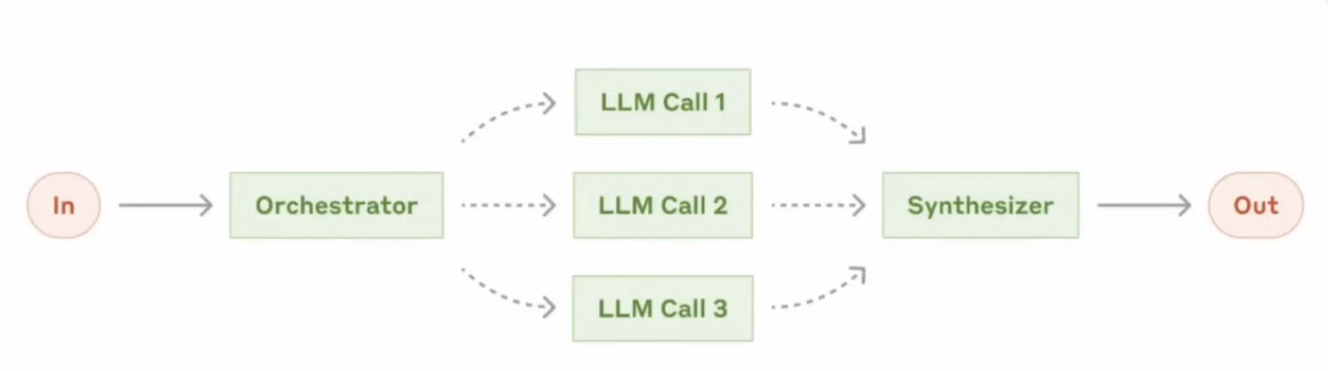

dynamic and we dont know how many workeres are being created

In [11]:
import os 
from langchain_openai import AzureChatOpenAI
import dotenv
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field

dotenv.load_dotenv()


llm = AzureChatOpenAI(
    openai_api_version=os.getenv("AZURE_OpenAI_API_VERSION_3"),
    azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL_3'),
    model_name=os.getenv('AZURE_OPENAI_DEPLOYMENT_MODEL_3'),
    api_key=os.getenv('OPENAI_API_KEY_3'),
    azure_endpoint=os.getenv('AZURE_OpenAI_ENDPOINT_3')
   )

llm.invoke('batman says what?').content

"Batman is known for his iconic one-liners and catchphrases that reflect his brooding, determined, and justice-driven personality. Here are a few famous things Batman says:\n\n1. **“I’m Batman.”** - His most famous introduction.\n2. **“It’s not who I am underneath, but what I do that defines me.”** – *Batman Begins (2005)*\n3. **“Because I’m the hero Gotham deserves, but not the one it needs right now.”** – *The Dark Knight (2008)*\n4. **“I have one rule.”** - Referring to his moral code, often around not killing.\n5. **“Criminals are a cowardly and superstitious lot.”** – A classic line from the comics.\n6. **“Justice, not vengeance.”** - Summing up his mission.\n\nOf course, Batman's tone often depends on the version: dark and brooding in some iterations, while witty and sharp in others! Which Batman quote or version are you thinking of? 😊"

In [9]:
from typing import Annotated, List 
import operator 

class Section(BaseModel):
    name: str=Field(
        description='Name for this section of report',
    )
    description:str=Field(
        description='Brief overview of main topics and concepts to be covered in this section'
    )

class Sections(BaseModel):
    sections:List[Section]=Field(
        description='sections of the report'
    )

planner=llm.with_structured_output(Sections)


In [21]:
# graph state 
class State(TypedDict):
    topic: str 
    sections: list[Section]
    completed_sections: Annotated[
        list, operator.add
    ]
    final_report:str 

# worker state :- work being done independently
class WorkerState(TypedDict):
    section:Section
    completed_sections: Annotated[list,operator.add]

In [25]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import Send 
# create nodes and edges 

def orchestrator(state:State):
    report_section=planner.invoke(
        [
            SystemMessage(content='Generate a plan for the report'),
            HumanMessage(content=f'Here is the report topic: {state["topic"]}')
        ]
    )
    return {'sections':report_section.sections}

# worker 
def llm_call(state:WorkerState):
    section=llm.invoke(
        [
            SystemMessage(content='Write a report section'),
            HumanMessage(content=f'here is the section name: {state["section"].name} and description: {state["section"].description}')
        ]
    )
    return {'completed_sections':[section.content]}

# write a completed section as a string 
def systhesizer(state:State):
    completed_sections=state['completed_sections']
    completed_sections_report='\n\n----\n\n'.join(completed_sections)

    return {'final_report':completed_sections_report}

# API in langgraph
def assign_workers(state:State):
    return [Send('llm_call',{'section':s}) for s in state['sections']]


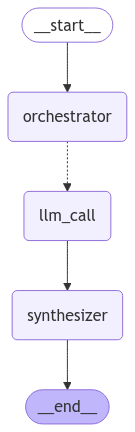

In [26]:
# build workflow 
orchestrator_workflow=StateGraph(State)

# Add node 
orchestrator_workflow.add_node('orchestrator',orchestrator)
orchestrator_workflow.add_node('llm_call',llm_call)
orchestrator_workflow.add_node('synthesizer',systhesizer)

# Add edge to connect nodes 
orchestrator_workflow.add_edge(START,'orchestrator')
orchestrator_workflow.add_conditional_edges(
    'orchestrator',assign_workers,['llm_call'])
orchestrator_workflow.add_edge('llm_call','synthesizer')
orchestrator_workflow.add_edge('synthesizer',END)

# Compile the workflow 
orchestrator_workflow=orchestrator_workflow.compile()
orchestrator_workflow

In [27]:
state=orchestrator_workflow.invoke({'topic':'Create a report on LLM scaling laws'})

In [28]:
from IPython.display import Markdown
Markdown(state['final_report'])

### Introduction to LLM Scaling Laws

Scaling laws are fundamental principles that describe how the performance or behavior of machine learning models, including large language models (LLMs), changes as a function of scale. These laws provide a quantitative framework for understanding the relationship between a model's size, the amount of data it is trained on, and the computational resources required. In recent years, scaling laws have emerged as critical tools for both theoretical insights and practical advancements in the development of LLMs.

Understanding scaling laws is particularly important in the realm of LLMs due to the unprecedented complexity and resource demands of these models. As LLMs grow larger, exhibiting billions or even trillions of parameters, scaling laws help researchers and engineers predict their performance gains and limitations. This includes insights into improvements in language understanding, generation quality, and downstream task performance as models are scaled.

By guiding resource allocation, architectural decisions, and training strategies, scaling laws serve as a roadmap for designing more efficient and effective LLMs. They enable researchers to identify optimal trade-offs between model size, training time, and dataset quality, ensuring that resources are used efficiently. Moreover, scaling laws often reveal asymptotic behaviors, highlighting the point of diminishing returns where increasing scale no longer yields proportional improvements.

In this section, we will provide an overview of the principles underlying scaling laws, their historical development, and their pivotal role in shaping the evolution of LLMs. Through this exploration, we aim to demystify the complexities of LLM scaling laws and underscore their significance in advancing state-of-the-art AI systems.

----

## Historical Development and Background

The evolution of large language models (LLMs) is a testament to the rapid advancements in computational linguistics, artificial intelligence, and machine learning. From their early inception to their present state, LLMs have undergone significant transformations, driven by the convergence of theoretical innovations, increasing computational power, and the availability of large-scale datasets. This section explores the milestones in the development of LLMs and the emergence of scaling laws, which have become a key guiding principle in model design and training.

### Early Foundations

The roots of LLMs lie in the foundational work on statistical language models in the late 20th century. Techniques such as n-grams, hidden Markov models, and early neural networks provided the initial building blocks for computational approaches to natural language processing (NLP). However, these early models were limited by their reliance on hand-engineered features, assumptions of linearity, and their inability to effectively model long-range dependencies in sequences.

The advent of word embeddings, particularly through methods such as Word2Vec (Mikolov et al., 2013) and GloVe (Pennington et al., 2014), marked a significant turning point. These techniques demonstrated the power of distributed representations, where words were embedded in continuous vector spaces to capture semantic and syntactic relationships. This laid the groundwork for more sophisticated models that could process text holistically.

### Ascendancy of Neural Language Models

The introduction of the transformer architecture by Vaswani et al. in 2017 represented a paradigm shift in the field. Transformers replaced recurrent neural networks (RNNs) and long short-term memory (LSTM) networks as the dominant architecture for sequence modeling tasks, thanks to their scalability and ability to process input sequences in parallel using the self-attention mechanism. This innovation drastically improved the efficiency and performance of NLP systems, especially in tasks requiring contextual understanding of text.

The release of transformer-based models, such as OpenAI’s GPT series, Google’s BERT, and later models like T5 and RoBERTa, showcased the power of pre-trained, fine-tuned LLMs for a wide array of downstream applications. These models were characterized by their rapidly increasing sizes, both in terms of parameters and training data, as researchers discovered that scaling up model capacity led to significant improvements in performance.

### Emergence of Scaling Laws

As LLMs continued to grow in size and complexity, researchers began to observe consistent patterns between model performance, size, and resource utilization. This phenomenon, known as scaling laws, was first rigorously examined in studies such as those by OpenAI and DeepMind. Scaling laws demonstrated that increasing the size of models, training data, and computation in a balanced manner resulted in predictable and sustained performance gains.

These findings have reshaped the trajectory of LLM development, encouraging the design of models with hundreds of billions—and even trillions—of parameters. Importantly, scaling laws underscore the non-linear relationship between model size and performance; larger models exhibit emergent behaviors and capabilities not seen in their smaller counterparts, such as zero-shot and few-shot learning.

### Challenges and Limitations in Scaling

While scaling has unlocked unprecedented capabilities in LLMs, it has also posed challenges related to computational cost, energy efficiency, and ethical considerations. Training state-of-the-art models requires massive infrastructure and resources, raising questions of accessibility and sustainability. Moreover, scaling laws are not without limitations; while they provide a roadmap for performance improvements, they cannot compensate for deficiencies in data quality or address biases and inaccuracies inherent in training datasets.

### Conclusion

The historical development and emergence of scaling laws exemplify the iterative and data-driven nature of AI research. From early statistical models to revolutionary transformer-based architectures, LLMs have evolved in tandem with technological breakthroughs. Scaling laws now serve as a critical framework for understanding and optimizing the performance of LLMs, guiding both academic research and industrial applications toward new frontiers in natural language understanding.

----

### Core Concepts and Definitions

This section provides a critical foundation by defining and clarifying key concepts essential for understanding the relationships between model parameters, data size scaling, computation budgets, and overall model efficiency. By establishing a clear framework, we aim to ensure consistency in interpretation and facilitate a common language for discussing these interconnected aspects of machine learning systems.

**Parameters**: Parameters are the internal weights and biases that a model learns during the training process. These numerical values determine how the model processes input data to produce outputs. The size of a model, often referred to as its "parameter count," is a critical factor that impacts its capacity to learn complex patterns. Larger models, with more parameters, are generally more expressive and capable of handling richer datasets. However, they also demand greater computational resources and are more susceptible to overfitting on smaller datasets.

**Data Size Scaling**: This refers to the relationship between the size of the training dataset and a model's ability to achieve optimal results. As models scale in size, their performance often depends on access to proportionally larger datasets to prevent underutilization of capacity or overfitting. Understanding this relationship is vital for designing training pipelines that can leverage the full potential of large-scale models without falling victim to bottlenecks in data quality or diversity.

**Computation Budget Implications**: The computational cost of training and deploying machine learning models is a key consideration in practical applications. It includes factors such as the number of operations required per forward pass, memory usage, and power consumption. As models grow in size or complexity, their required computation budgets also increase, often exponentially. Proper allocation of computational resources is crucial for balancing performance improvements with constraints such as energy efficiency, hardware limitations, and environmental impact.

**Model Efficiency**: Model efficiency is a measure of how effectively a model achieves its performance objectives relative to the resources it consumes, including time, computation, and energy. Efficient model design involves optimization techniques such as sparsity, parameter sharing, and pruning to reduce resource consumption without significantly sacrificing accuracy. Efficiency plays a critical role in scaling model deployment for real-world applications, particularly when operating under stringent hardware or latency constraints.

By clearly delineating these core concepts, this section sets the stage for deeper exploration of how they interact and influence one another. Understanding these foundational ideas is a prerequisite to effectively addressing the challenges of scaling models while maintaining practical feasibility and efficiency.

----

### Empirical Studies and Findings

The section on empirical studies and findings is fundamental to understanding the development, validation, and implications of scaling laws. Over the past decade, a growing body of research has rigorously investigated how the performance of machine learning systems improves as a function of model size, dataset size, and computational resources. These studies not only establish theoretical frameworks for scaling laws but also provide quantitative evidence to guide model development and deployment in practice. Below, we examine the key primary studies that have advanced this area, with attention to their methodologies and findings.

#### Key Studies Establishing Scaling Laws

1. **Kaplan et al. (2020): Scaling Laws for Neural Language Models**
   A pivotal study by Kaplan et al. provided the foundational empirical basis for scaling laws in neural language models. The researchers systematically analyzed the relationships between model performance (e.g., cross-entropy loss), model size (parameters), dataset size, and computation budget (FLOPs). Using a series of transformer-based language models trained on large-scale textual datasets, the study made three primary observations:
   - Model performance improves predictably and continuously with increases in model size and training dataset size, following a power-law relationship.
   - At any fixed computation budget, optimizing the allocation of resources (e.g., larger models vs. more training data) is critical for achieving maximum performance.
   - Diminishing returns occur at large scales, but the performance ceiling can be shifted upward by increasing another variable (e.g., dataset size).

   These findings cemented a quantitative understanding of scaling behavior and highlighted the importance of balancing the three main resources (model size, data, compute).

2. **Hoffmann et al. (2022): Training Compute–Optimal Large Language Models**
   Building upon Kaplan et al., Hoffmann et al. introduced a refined scaling framework to explore compute-optimality in large language models. While earlier studies assumed a fixed relationship between model size and data size, Hoffmann et al. discovered that many models in the field underperform because they are overparameterized relative to their available training data. This study established "chinchilla scaling laws," which recommend smaller models trained longer on larger datasets to achieve superior performance given a fixed compute budget. The revised methodology showed:
   - A shift in focus toward dataset size as the dominant variable for improving model performance.
   - The reduction of inefficiencies in resource allocation, making training more cost-effective.
   - Evidence that larger datasets allow for extrapolated generalization more effectively than purely increasing parameter count.

3. **Rosenfeld et al. (2019): Tuning Artificial Neural Networks with Scaling Laws**
   Rosenfeld and colleagues extended scaling laws to domains beyond language modeling, examining how scaling principles apply to vision and multimodal tasks. Their research demonstrated that the same underlying principles of power-law relationships persist across diverse architectures and tasks. They also highlighted areas where scaling predictions diverged due to domain-specific characteristics, such as input dimensionality or sparsity.

#### Methodologies Employed

The methodologies used in these studies exhibit distinct yet complementary approaches, including:
- **Controlled Scaling Experiments:** Systematic experimentation with varying independent variables (e.g., model size, dataset size) while keeping other factors constant to isolate causal relationships.
- **Extrapolation and Predictive Modeling:** Fitting empirical data points to theoretical curves to predict system behavior outside the training regime.
- **Benchmark Evaluations:** Testing scaled models on standard benchmark datasets to assess generalization and task-specific performance.

Common design practices include leveraging massive compute clusters, large-scale datasets, and precise parameter tuning to ensure replicability and generality of findings.

#### Summary of Findings

The collective insights from these empirical studies can be summarized as follows:
- Scaling laws reveal predictable patterns in how increased resources impact performance, providing a roadmap for efficient resource allocation.
- Dataset quality and size increasingly dominate as determining factors for model success, often more than parameter count.
- Despite diminishing returns, scaling laws suggest that substantially increasing resources (up to practical limits) can continue to yield meaningful improvements.

These findings have far-reaching implications. They inform resource allocation in both research and industry contexts, guide theoretical investigations into model limitations, and highlight the need for sustainable computational practices. Furthermore, they underscore the importance of continuing to refine scaling laws as systems grow in complexity, tasks diversify, and the demand for efficiency accelerates.

----

### Scaling Laws and Predictions for Performance Optimization

The development and optimization of large language models (LLMs) have been significantly influenced by the discovery and application of scaling laws. These laws provide a systematic framework to understand how changes in model size, dataset size, and computational resources impact performance, enabling researchers and engineers to make informed decisions regarding model architecture and training strategies. This section explores the foundational concepts of scaling laws, how they guide the design of optimized LLM architectures, and practical examples that demonstrate their effectiveness.

#### Understanding Scaling Laws in LLMs

Scaling laws are mathematical relationships that describe how a model's performance improves as we scale up its components. Research has shown that model performance, measured by metrics such as loss or accuracy on a specific task, tends to follow predictable patterns when parameters like model size, dataset size, and computation are adjusted. For instance:

- **Model parameters scaling**: Increasing the number of parameters in a model, such as moving from a 1-billion-parameter architecture to one with hundreds of billions of parameters, typically leads to improved performance if done properly.
- **Dataset scaling**: Expanding the dataset size in tandem with model size often yields further performance gains, assuming the additional data is high-quality and diverse.
- **Compute scaling**: A sufficient allocation of computational resources is required to train larger models effectively, with diminishing returns observed beyond certain thresholds.

#### Pareto Efficiency: Balancing Model-Dataset-Compute Scaling

One of the key insights revealed by scaling laws is the principle of Pareto efficiency, where optimal performance is achieved by balancing model size, dataset quantity, and computation. Disproportionally increasing one resource—such as making a model larger without increasing its training dataset—can lead to diminishing returns and potential overfitting. Understanding the tradeoffs between these factors is critical for designing cost-effective LLMs that reach near-optimal performance under given constraints.

#### Examples of Scaling Law Applications

1. **GPT Series**: Scaling laws played a pivotal role in the design of OpenAI’s GPT models. Experiments with earlier versions informed decisions on expanding model size, dataset volume, and computational requirements, resulting in the development of progressively more powerful iterations like GPT-3 and GPT-4.

2. **Chinchilla Optimization**: DeepMind’s Chinchilla model showcased the importance of scaling dataset size alongside model parameters. Unlike earlier models that prioritized parameter growth, Chinchilla followed a more data-efficient approach by increasing the dataset size to match the compute budget. This resulted in a significant improvement in performance compared to similarly sized models trained on smaller datasets.

3. **Sparse Mixture-of-Experts (MoE)**: Scaling laws also inform architectural innovations such as sparse networks, where only a subset of model parameters is active during computation. Models like Switch Transformer leverage these laws to achieve comparable performance to dense models with reduced computational costs.

#### Predictions Enabled by Scaling Laws

Scaling laws provide a powerful tool not only for retrospective analysis but also for forward-looking predictions. For instance, they can estimate the performance of hypothetical future models based on current trends in parameter growth, data availability, and compute efficiency. Such predictions are instrumental for guiding research investments, pre-empting bottlenecks, and formulating long-term development strategies.

Furthermore, as scaling laws continue to evolve, they are likely to uncover asymptotic limits for LLM performance—points at which further scaling yields negligible gains. This could encourage the research community to shift focus toward alternative strategies, such as architectural innovations, task-specific fine-tuning, or optimization of inference/training frameworks.

#### Key Takeaways

Scaling laws have revolutionized the design and optimization of LLMs by providing actionable insights into the interplay between model size, dataset scope, and computational resources. These laws serve as a roadmap for building increasingly powerful models while maintaining cost-efficiency and performance balance. By integrating these principles, researchers and practitioners can not only optimize current architectures but also anticipate the capabilities and limitations of next-generation LLMs.

----

## Case Studies and Applications

Scaling laws have emerged as a crucial framework for understanding and designing effective large language models (LLMs). By analyzing relationships between model size, data volume, and computational resources, researchers and engineers have been able to predict improvements in model performance and guide development decisions. In this section, we highlight several case studies and practical applications where scaling laws have been successfully implemented to create state-of-the-art LLMs, underscoring their transformative impact on natural language processing (NLP).

### Case Study 1: OpenAI's GPT Series
One of the most prominent examples of leveraging scaling laws is OpenAI's development of the GPT series. In their 2020 paper on scaling laws for neural language models, researchers demonstrated how performance improvements adhere to predictable patterns when increasing the number of model parameters, dataset size, and computational resources. This work informed the evolution from GPT-2 to GPT-3, which scaled to 175 billion parameters, setting new benchmarks for NLP tasks. By using scaling laws, the team was able to make trade-offs between model size and dataset quality, ensuring optimal use of compute resources while delivering unprecedented language generation capabilities.

### Case Study 2: DeepMind’s Gopher and Chinchilla
DeepMind’s comparative studies of LLMs provided another compelling application of scaling laws. The development of Gopher (280 billion parameters) and subsequent investigations into model performance revealed that many large-scale models were undertrained relative to their size. This led to the introduction of Chinchilla, a smaller model (70 billion parameters) trained on significantly more data. By adhering to scaling law principles, Chinchilla outperformed larger models while using fewer parameters, illustrating the value of balancing model size and training data to maximize efficiency.

### Case Study 3: Microsoft and Turing-NLG
Microsoft's Turing-NLG is another example where scaling laws shaped design goals. With 17 billion parameters, it was, at its release, one of the largest language models publicly disclosed. The design process was heavily influenced by insights from scaling research, enabling the development team to systematically assess how larger models could enhance downstream tasks such as summarization, translation, and question answering. These scaling-informed decisions allowed Microsoft to create a model capable of supporting diverse applications across its suite of enterprise solutions.

### Application Areas
Beyond academia and corporate research, scaling laws have found numerous real-world applications. In domains such as healthcare, finance, and education, scaling laws have guided the development of specialized LLMs by tailoring model size and training regimens to specific industry needs. For instance:
- **Healthcare**: Custom LLMs trained on vast medical literature incorporate scaling principles to efficiently manage computational demands while delivering accurate diagnostic assistance or language understanding for patient records.
- **Finance**: Financial institutions deploy LLMs optimized through scaling laws to handle large volumes of transactional data and generate insights, forecasts, and automatic reports.
- **Education**: EdTech platforms use LLMs tailored with scaling-informed practices to deliver personalized learning experiences, real-time feedback, and advanced content delivery systems.

### Challenges and Future Directions
While scaling laws have significantly advanced the state of NLP, applying these laws in practice is not without challenges. Balancing the environmental impact of resource-intensive models against performance gains is an ongoing concern. Additionally, scaling laws alone cannot address issues like biases, interpretability, and emergent behaviors in LLMs. Future work may involve integrating scaling principles with ethical considerations and new architectural innovations to further enhance the practical applications of LLMs.

By examining these case studies and applications, it is clear that scaling laws have provided a robust foundation for designing not only larger but also more effective and efficient LLMs. As these principles continue to evolve, they will play a pivotal role in shaping the next generation of innovations in artificial intelligence.

----

### Challenges and Limitations

Scaling laws have emerged as powerful tools for predicting system behavior and guiding design choices across various domains, including machine learning, physics, and engineering. However, their applicability is not without challenges and constraints, particularly when transitioning from theoretical formulations to real-world implementations. This section highlights the primary obstacles encountered when adhering to scaling laws and explores the inherent limitations they present in practical scenarios.

#### Challenges in Adhering to Scaling Laws

1. **Model Complexity and Deviation from Assumptions**  
   Scaling laws often rely on simplified mathematical models or ideal conditions that may not fully capture the complexity of real systems. In practice, systems frequently deviate from these assumptions due to non-linearities, emergent behaviors, or external factors, leading to discrepancies between predicted and actual performance.

2. **Resource Constraints**  
   Many scaling laws suggest exponential resource requirements, such as computational power, memory, or data availability, to achieve desired improvements. For instance, in machine learning, scaling model size or training data might result in diminishing returns if infrastructure or budgets cannot keep pace. These resource constraints act as a significant barrier to implementing scaling laws at the intended scale.

3. **Uncertainty in Generalization**  
   The generalizability of scaling laws across different domains or scenarios is not always guaranteed. For example, laws that are derived from controlled laboratory experiments or synthetic datasets may fail to account for variability in real-world data, which can be messy, incomplete, or biased.

4. **Environmental and Ethical Concerns**  
   Following some scaling laws, especially in energy-intensive domains like large-scale AI models, raises questions about environmental sustainability. The demand for increased energy consumption and hardware production can exacerbate ecological impact, creating ethical dilemmas that challenge their unbounded application.

5. **Physical and Technical Constraints**  
   At certain scales, physical and technical limitations come into play. For instance, in microelectronics or hardware scaling, phenomena like quantum effects, heat dissipation, or manufacturing limitations can make further scaling impractical or economically unviable.

#### Limitations of Scaling Laws in Real-World Scenarios

1. **Context-Specific Applicability**  
   Scaling laws are not universal; their validity depends on the specific context in which they are applied. A law derived for one system cannot necessarily be extended to another without significant adaptations or caveats.

2. **Diminishing Returns**  
   Many scaling laws exhibit diminishing returns, where gains in performance or efficiency plateau as scale increases. This limitation necessitates trade-offs, requiring careful evaluation of the cost-benefit ratio when pursuing higher scales.

3. **Short-Term vs. Long-Term Utility**  
   While scaling laws provide valuable insights in the short term, they may fail to account for second-order effects or disruptions that come with extended use. For example, market shifts, resource scarcity, or changes in foundational technologies can render a scaling law obsolete over time.

4. **Inability to Capture Interdependencies**  
   Real-world systems are inherently interconnected, and scaling one component based on isolated laws may lead to unintended consequences in other parts of the system. For instance, scaling a hardware component without parallel advancements in software optimization can result in inefficiencies or bottlenecks.

5. **Risk of Over-Reliance**  
   Blind adherence to scaling laws risks stifling innovation by constraining problem-solving to predetermined trajectories. This over-reliance can overshadow alternative approaches or fundamentally new paradigms that do not conform to existing scaling metrics.

In summary, while scaling laws serve as invaluable frameworks for growth and optimization, their practical application is accompanied by a host of challenges and limitations. These factors must be carefully considered to ensure that scaling efforts are feasible, sustainable, and contextually relevant in dynamic real-world environments.

----

### Future Directions and Open Questions

As research on scaling laws continues to deepen our understanding of machine learning systems, future advancements are likely to be driven by both theoretical exploration and empirical breakthroughs. The scaling laws paradigm—which examines how model performance responds to changes in resource allocation such as data, compute, and model parameters—has revealed numerous insights. However, the field is still in its relative infancy, with several open questions and uncharted directions that beckon further investigation. Below, we outline some potential trajectories for future research as well as key questions that remain unresolved in this domain.

#### 1. **Beyond Power Laws: Refining Generality and Robustness**  
   While many current scaling laws rely heavily on power-law relationships to predict the behavior of machine learning models, real-world deviations suggest that these approximations may not always hold. Future work could involve developing richer functional forms that account for phenomena such as diminishing returns, regime shifts (e.g., saturation effects), and sudden performance plateaus or breakthroughs. Questions of interest include:
   - What causes deviations from power-law behavior, and how can we model these anomalies?
   - Can we derive universal scaling laws applicable across more diverse domains (e.g., vision, language, reinforcement learning)?
   - Are there domain-specific nuances in scaling that need to be incorporated into generalized frameworks?

#### 2. **Multi-Modal Systems and Cross-Domain Scaling**  
   As multi-modal systems become increasingly prevalent, understanding how scaling laws generalize to models that process and integrate information across different domains (e.g., text, images, audio, and video) remains an open frontier. Investigating how resource allocation across modalities impacts performance could unlock critical insights:
   - How do scaling dynamics differ for single-modality models versus multi-modal systems?
   - Are there interaction effects or synergies when scaling multi-modal architectures?  
   - What scaling rules govern pretraining and fine-tuning efficiency for multi-modal tasks?

#### 3. **Scaling Beyond Current Resource Constraints**  
   Many existing scaling studies focus on the upper limits of contemporary computational resources, yet questions about the behavior of models in asymptotic or hypothetical scenarios are underexplored. These questions may extend to the ethical and environmental challenges of large-scale training:
   - How will scaling laws evolve with the advent of more efficient hardware (e.g., specialized accelerators) or new computing paradigms (e.g., quantum computing)?  
   - Are there theoretical upper bounds or resource ceilings, beyond which scaling leads to fundamentally diminishing returns?
   - How do we design scaling methodologies that minimize energy consumption while maximizing performance?

#### 4. **Data Scaling and Quality**  
   A critical factor in scaling laws is not only the quantity of data but its quality and diversity. The effects of noisy, biased, or redundant data on scaling trajectories remain incompletely understood. Furthermore, understanding how data-centric approaches interact with model scaling raises pressing questions:
   - How does data quality influence the efficiency of scaling laws?  
   - Does the concept of scaling extend meaningfully to dynamic datasets that continuously evolve and adapt?
   - Can we develop scaling theories that explicitly quantify the trade-offs between data volume, diversity, and informativeness?

#### 5. **Theoretical Foundations of Scaling**  
   Many current scaling laws are empirical in nature, derived from experiments with specific architectures and datasets. A more rigorous theoretical framework to explain and predict scaling behavior across different contexts would provide substantial benefits:
   - Can we derive scaling laws from first principles of statistical learning theory or other mathematical foundations?  
   - Are there connections between scaling behavior and the geometry of model parameter spaces or optimization trajectories?
   - How do factors like overparameterization, sparsity, and priors interact with scaling mechanics?

#### 6. **Emergent Phenomena and Capabilities**  
   One of the most intriguing questions in scaling research centers on the emergence of new capabilities in large models, such as in-context learning or zero-shot reasoning. These phenomena offer opportunities for exploration:
   - What drives the emergence of qualitatively new behaviors in models as they scale?  
   - Are there specific thresholds (in terms of data, compute, or model size) at which emergence reliably occurs?
   - Can we predict and control emergent properties during the scaling process?

#### 7. **Interdisciplinary Perspectives and Applications**  
   Lastly, scaling laws research can benefit from closer integration with disciplines outside computer science, such as neuroscience, cognitive science, and economics. These collaborations may help address:
   - How do scaling behaviors in artificial systems correspond to learning and generalization in biological systems?  
   - Can scaling insights help us improve real-world systems, such as adaptive learning algorithms in education, or accelerate drug discovery?
   - How do economic models of resource allocation intersect with computational scaling strategies?

### Concluding Thoughts
The study of scaling laws remains a fertile area of inquiry, offering profound opportunities to better understand the principles that govern machine learning systems at scale. Addressing the open questions and challenges outlined here will require not only innovation in machine learning methodologies but also thoughtful collaboration across disciplines. By uncovering the theoretical underpinnings and practical implications of scaling, the field has the potential to influence both the development of artificial intelligence and its responsible deployment in society.

----

## Conclusion and Summary

Scaling laws in large language models (LLMs) have emerged as a cornerstone of modern artificial intelligence research, offering a groundbreaking framework for understanding how model performance improves with increases in size, data, and computational resources. These laws provide critical insights into the predictable relationship between the scale of a model and its capabilities, shaping how researchers and engineers optimize resources to achieve state-of-the-art results.

Through the consistent application of scaling laws, researchers have been able to better quantify the trade-offs between model size, training duration, and data quality. This has not only minimized experimental guesswork but also accelerated the pace of innovation in natural language processing (NLP). By emphasizing the importance of parameters, token counts, and compute budgets, scaling laws have guided the development of models that push the boundaries of what AI systems can achieve, ranging from improved generative capabilities to nuanced understanding of complex linguistic patterns.

Moreover, the implications of scaling laws extend beyond technical achievements. They have contributed to robust benchmarking practices, enabling fair comparisons across different models. These insights have also driven the democratization of AI, inspiring the creation of smaller yet highly efficient models that balance performance with accessibility for those with limited computational resources. Scaling laws have catalyzed exploration in transfer learning, fine-tuning strategies, and emergent behaviors, opening new avenues for solving real-world problems.

As we look ahead, the enduring relevance of scaling laws will be foundational to addressing both the opportunities and challenges in LLM research. From guiding investment in infrastructure to managing the ethical considerations of model deployment, the scalability-driven paradigm will continue to inform how AI evolves. In conclusion, the study and application of scaling laws represent not merely a technical milestone but a transformative shift in how we approach the design, training, and implementation of large-scale AI systems, shaping the future of both development and research in profound ways.

In [29]:
state=orchestrator_workflow.invoke({'topic':'attention is all you need'})

In [30]:
Markdown(state['final_report'])

**Introduction and Description**

In the evolving landscape of artificial intelligence and machine learning, neural architectures have become the backbone of state-of-the-art solutions to complex problems, ranging from natural language processing (NLP) to computer vision and beyond. As these architectures grow more sophisticated, so does the need to focus computational resources efficiently. This need has propelled attention mechanisms to the forefront of research and application, serving as a pivotal innovation in modern neural network design.

The concept of attention mirrors cognitive processes in humans, where focus is directed selectively toward relevant stimuli while ignoring extraneous information. By incorporating such mechanisms into neural architectures, models can dynamically prioritize specific parts of input data, enhancing their ability to capture long-range relationships, process sequential patterns, and improve overall interpretability. Whether it is attending to key words in a sentence, critical regions in an image, or salient features in multimodal inputs, attention mechanisms empower neural networks to handle tasks more effectively by concentrating on what matters most.

This paper aims to provide an in-depth exploration of attention as a central construct in neural network architectures. We examine its historical evolution, mathematical underpinnings, and diverse applications in key domains. By highlighting the transformative impact of attention mechanisms, particularly in breakthroughs like the Transformer model, we seek to underscore why and how attention has become a cornerstone of contemporary AI systems. Additionally, this paper delves into the limitations of attention mechanisms and their potential future directions, exploring ways to refine and expand their capabilities.

The overarching goal of this work is not only to provide a comprehensive understanding of attention mechanisms but also to present insights into their practical implications for designing next-generation AI architectures. By situating attention at the heart of our discussion, we aim to illuminate its role as both a theoretical advancement and a pragmatic tool that continues to reshape the boundaries of artificial intelligence.

----

## Attention Mechanism

The **attention mechanism** is a fundamental innovation in the field of machine learning that has revolutionized how neural networks process information. Originally introduced to enhance sequence-to-sequence models, particularly in tasks like machine translation, the attention mechanism has since become a cornerstone of many state-of-the-art machine learning architectures, including transformers, BERT, and GPT models.

### How the Attention Mechanism Works

At its core, the attention mechanism enables a model to dynamically focus on relevant portions of the input data while processing a task. Unlike traditional sequence models that encode all input into a fixed-size representation, attention allows the model to compute a weighted sum of the input states, where the weights are determined by the relevance of each input to the current processing step.

1. **Key, Query, and Value**:  
   The attention mechanism typically operates through three main components: the query (Q), the key (K), and the value (V). These are vector representations derived from the input data. The mechanism computes the similarity between the query and the keys to assess the importance of each piece of input data. The resulting scores are normalized, often using a softmax function, to produce attention weights, which are then applied to the values.

2. **Self-Attention**:  
   A significant breakthrough of attention is its self-attention configuration, where the queries, keys, and values come from the same sequence. In this setup, the model learns to assign varying levels of importance to different elements within the sequence itself. This is particularly valuable for tasks involving long-range dependencies, as it allows the model to focus on contextually relevant parts of the input.

3. **Multi-Head Attention**:  
   To capture diverse aspects of the input data, the mechanism is often extended into a multi-head attention structure. Multiple attention heads independently compute attention weights, and their outputs are concatenated and transformed. This enables the model to simultaneously attend to different information subspaces, fostering richer representations.

### Why Attention Is Crucial

The attention mechanism addresses many limitations of prior machine learning models, such as recurrent neural networks (RNNs), which struggled with long-term dependencies and computational inefficiencies. By allowing direct interactions between all input positions, attention facilitates:

- **Improved Context Understanding**: The ability to focus on contextually important features enables more effective comprehension of complex sequences, such as language and time-series data.
- **Parallel Computation**: Unlike RNNs, which process inputs sequentially, attention can handle data in parallel, significantly boosting computational efficiency.
- **Scalability**: The mechanism's modularity and adaptability have made it the foundation for many scalable architectures, like transformers, capable of handling massive datasets and tasks with high dimensionality.

In addition to its transformative role in natural language processing, attention has been applied across diverse domains, including computer vision, speech recognition, and reinforcement learning. Innovations such as vision transformers (ViTs) and cross-attention in multimodal models extend its utility even further.

The introduction of the attention mechanism has ushered in a new era for machine learning, allowing models to intelligently allocate focus and better process complex relationships within data. As a result, it continues to drive performance improvements and expand the frontier of what machine learning systems can achieve.

----

### Key Contributions

The seminal paper *"Attention is All You Need"* by Vaswani et al. (2017) introduced groundbreaking innovations that revolutionized the field of natural language processing (NLP) and machine learning as a whole. Central to this was the introduction of the Transformer architecture, which redefined sequence-to-sequence modeling by eliminating dependence on recurrent or convolutional mechanisms in favor of self-attention mechanisms. This section discusses the paper's key contributions in detail, highlighting its transformative impact on the field.

#### 1. **The Transformer Architecture**
   The Transformer architecture is the centerpiece of the paper and represents a paradigm shift in deep learning models for sequential data. Unlike its predecessors—which relied heavily on Recurrent Neural Networks (RNNs), Long Short-Term Memory networks (LSTMs), or Convolutional Neural Networks (CNNs)—the Transformer operates entirely through attention mechanisms. Key aspects of the architecture include:
   
   - **Self-Attention Mechanism:** The paper introduced the concept of self-attention as a way to model dependencies between all elements in a sequence simultaneously, regardless of their distance. This mechanism ensures efficient computation of relationships while preserving the richness of contextual information.
   - **Positional Encoding:** To overcome the absence of sequential structure in the input, the authors devised a positional encoding scheme to inject information about token order directly into input embeddings, maintaining sequential understanding without recurrence.
   - **Decoder-Encoder Framework:** The Transformer comprises an encoder-decoder structure where both components rely exclusively on attention layers and feed-forward neural networks. This modular design allows for parallelizable operations and scalability.

#### 2. **Efficiency and Scalability**
   One of the key innovations of the Transformer is its computational efficiency. By replacing RNNs with self-attention, the architecture drastically reduces the need for sequential computations, enabling parallel processing. This scalability not only facilitates faster training but also makes the architecture suitable for processing very large datasets, such as those required for training modern language models like GPT and BERT.

#### 3. **Multi-Head Attention**
   The introduction of multi-head attention stands out as a major methodological contribution. By using multiple attention heads, the model can learn and capture diverse relationships within the input data in parallel. This allows the Transformer to focus on different subsets of information simultaneously, leading to richer representations and stronger predictive performance.

#### 4. **Wide Applicability Beyond NLP**
   While the primary focus of the paper was on machine translation tasks, the underlying principles and design of the Transformer architecture have demonstrated wide applicability far beyond NLP. The Transformer has since been successfully adapted for a range of tasks, such as computer vision (Vision Transformers), reinforcement learning, and even molecular biology. This versatility underscores the broad implications of the paper's contributions.

#### 5. **Driving the Era of Pretrained Language Models**
   The Transformer laid the foundational groundwork for subsequent innovations like BERT, GPT, and T5, which dominate the modern NLP landscape. By demonstrating the effectiveness of self-attention mechanisms and transfer learning, the paper pioneered the development of pretrained language models, which have become ubiquitous in both academic research and real-world applications.

#### 6. **Simplification of Model Design**
   By removing the need for recurrence or convolution, the Transformer simplifies the model architecture while achieving superior performance. This simplification has made it easier for researchers and practitioners to understand, implement, and adapt the architecture across diverse domains.

In summary, the *"Attention is All You Need"* paper introduced a transformative approach to neural network design, with self-attention and the Transformer architecture at its core. Its contributions continue to fuel innovations across disciplines, solidifying its place as one of the most influential works in the history of machine learning.

----

### Applications and Description 

Attention mechanisms have revolutionized numerous fields of artificial intelligence and machine learning by enabling models to focus on the most relevant parts of the input data. This section explores the profound impact of attention mechanisms across various domains, including natural language processing (NLP), computer vision, and beyond.

#### 1. **Natural Language Processing (NLP)**  
Attention mechanisms have become a cornerstone of modern NLP applications, driving advancements in tasks such as machine translation, text summarization, sentiment analysis, and question-answering systems. The introduction of models like the Transformer architecture, which heavily relies on self-attention mechanisms, has significantly improved the ability of NLP systems to understand long-range dependencies and complex syntactic structures. For example:
   - **Machine Translation**: Attention mechanisms allow models to focus dynamically on the most relevant words in a source sentence when generating target translations, thereby improving contextual accuracy.
   - **Text Summarization**: By identifying key phrases and sentences, attention-based models produce coherent and concise summaries.
   - **Chatbots and Conversational AI**: Attention allows responses to be contextually aware, considering previous interactions and intents present in user queries.

#### 2. **Computer Vision**  
In computer vision, attention mechanisms enable models to selectively focus on the most informative regions of an image or video, drastically improving performance for complex visual recognition tasks. Applications include:
   - **Image Classification**: Spatial attention highlights regions of an image that contribute most to the classification decision.
   - **Object Detection**: Models incorporate attention to focus on localizing objects of interest in an image while ignoring irrelevant background information.
   - **Image Captioning**: Attention mechanisms align visual features with words, aiding in generating rich and semantically accurate descriptions of visual content.

#### 3. **Reinforcement Learning (RL)**  
In reinforcement learning, attention mechanisms have introduced novel ways to improve decision-making by helping agents prioritize key aspects of the environment. Applications include:
   - **Game Playing**: Attention mechanisms guide RL agents to evaluate game scenarios more effectively by concentrating on critical states or game elements.
   - **Robotics**: Attention helps robots manage resources efficiently by attending to relevant sensory inputs, such as specific objects or paths in a cluttered workspace.

#### 4. **Healthcare**  
The ability of attention mechanisms to highlight critical patterns in data has made them particularly well-suited for healthcare applications:
   - **Medical Imaging**: In areas such as radiology and pathology, attention models assist in detecting anomalies by focusing on regions of interest in scans.
   - **Patient Monitoring**: Time-series attention models analyze vital signs or other physiological data, identifying critical changes that require intervention.

#### 5. **Finance**  
Financial systems leverage attention mechanisms to handle vast amounts of sequential and structural data for tasks like stock prediction, fraud detection, and portfolio management. Attention enhances these models by pinpointing significant trends and outliers, enabling more accurate analyses and decision-making.

### Emerging Use Cases  
The adaptability of attention-based models makes them applicable to a growing number of other fields, including:
   - **Autonomous Vehicles**: Attention guides perception systems to focus on relevant road factors such as pedestrians, signs, and obstacles.
   - **Education Technology**: Personalized learning platforms employ attention mechanisms to adaptively focus on student weaknesses and tailor educational content in real time.
   - **Logistics and Supply Chain Management**: Dynamic attention supports planning and optimization by emphasizing priority routes, suppliers, or products in complex systems.

In conclusion, the introduction of attention mechanisms has been transformative across domains, improving model performance, interpretability, and efficiency. By incorporating the ability to selectively process relevant information, attention-driven methods have established themselves as a fundamental tool in the broader machine learning toolkit. Their continued evolution promises even greater advancements in the years to come.

----

## Conclusion and Description

The attention mechanism has emerged as a transformative framework in machine learning, demonstrating remarkable advancements across various domains in both research and applied settings. This report highlights the key findings surrounding the utility, adaptability, and potential of attention-based architectures, particularly in natural language processing (NLP), computer vision, and multimodal learning.

### Key Findings  
Attention mechanisms, such as those utilized in the Transformer architecture, have revolutionized the field of deep learning by enabling models to dynamically focus on the most relevant parts of the input data. This selective focus not only improves performance on large-scale, complex datasets but also enables more interpretable machine learning models. 

1. **Enhanced Performance**: The incorporation of attention mechanisms has led to state-of-the-art results in various applications, including machine translation, question answering, image captioning, and healthcare diagnostics. Models such as BERT, GPT, and Vision Transformers (ViTs) have set new benchmarks by effectively modeling long-range dependencies and context-sensitive phenomena.

2. **Generalization and Transfer Learning**: Attention-based models show remarkable abilities in transfer learning, excelling at fine-tuning across diverse tasks with minimal labeled data. This capability reduces the demand for large task-specific datasets while further accelerating innovation in resource-constrained domains.

3. **Scalability and Efficiency Challenges**: Despite their success, attention mechanisms pose challenges related to computational efficiency and memory consumption as input sequences grow. Recent advancements such as sparse attention, low-rank approximations, and hybrid architectures demonstrate the ongoing effort to address these limitations.

4. **Application Diversity**: Beyond natural language and vision, attention mechanisms have been increasingly applied in multiscale, interdisciplinary contexts such as biology, finance, and human-computer interaction, underscoring their versatility and adaptability.

### Future Potential  
The future of the attention mechanism is characterized by rich opportunities for exploration and application:

1. **Efficient Architectures**: Research into lightweight attention models optimized for energy and computational cost will be pivotal as the demand for scalable AI systems grows, especially for deployment on edge devices and in low-resource settings.

2. **Interdisciplinary Expansion**: As attention-based models are further refined, their application in emerging fields such as neuroscience, personalized medicine, and climate modeling can lead to groundbreaking discoveries and enhanced decision-making capabilities.

3. **Explainability and Trust**: With increased reliance on AI systems in critical domains, there is a pressing need to enhance model interpretability. Attention mechanisms, by their inherent design, offer a promising avenue to better understand model decisions, thereby building trustworthiness and ethical accountability.

4. **Integration with Other Paradigms**: The combination of attention mechanisms with other paradigms such as reinforcement learning, causal modeling, and graph neural networks holds immense promise. These integrations could extend the capabilities of AI systems to tackle more complex, dynamic, and relational problems.

### Final Thoughts  
In conclusion, the attention mechanism stands as one of the most significant advancements in modern AI, reshaping the boundaries of what models can achieve. Its adaptability, combined with continuous innovations to address limitations, presages a future where attention-based systems play an integral role in solving some of the world's most pressing challenges. Researchers and practitioners are well-positioned to harness its full potential as new frontiers in machine learning and applications continue to unfold.